In [147]:
from io import StringIO

import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl

np.random.seed(0)
N_flights = 30
min_duration = 1
max_duration = 4
max_departure = 24

# generate the list of flights
flight_times = np.zeros((N_flights, 2), 'int64')

for i_flight in range(N_flights):
    good = False

    start_flight = 0
    end_flight = 0

    while not good:
        start_flight = np.floor(max_departure * np.random.rand())
        end_flight = start_flight + 3 * np.ceil((max_duration + 1 - min_duration) * np.random.rand())

        if end_flight <= max_departure:
            good = True

    flight_times[i_flight, :] = start_flight, end_flight

FlightData = pd.DataFrame(flight_times)
FlightData.columns = ["Departure", "Arrival"]
#display(FlightData)

FlightDataToExport = FlightData.copy()
FlightDataToExport["ID"] = FlightDataToExport.index
FlightDataToExport = FlightDataToExport[["ID", "Departure", "Arrival"]]
breakpoints = np.arange(0, 40, 10)
components = [FlightDataToExport[breakpoints[i]:breakpoints[i + 1]] for i in range(len(breakpoints) - 1)]
FlightDataToPrint = np.concatenate([component.values for component in components], axis = 1)
FlightDataToPrint = pd.DataFrame(FlightDataToPrint)
FlightDataToPrint.columns = ["ID", "Departure", "Arrival"] * 3

In [149]:
with open('flight_data.txt', 'w') as f:
    f.write(FlightDataToPrint.to_latex(index = False))

Risky pairs before reoptimization:  9.0
    'pyomo.core.base.objective.ScalarObjective'>) on block AircraftAssignment
    with a new Component (type=<class
    'pyomo.core.base.objective.ScalarObjective'>). This is usually indicative
    of a modelling error. To avoid this warning, use block.del_component() and
    block.add_component().
Risky pairs after reoptimization:  2.0


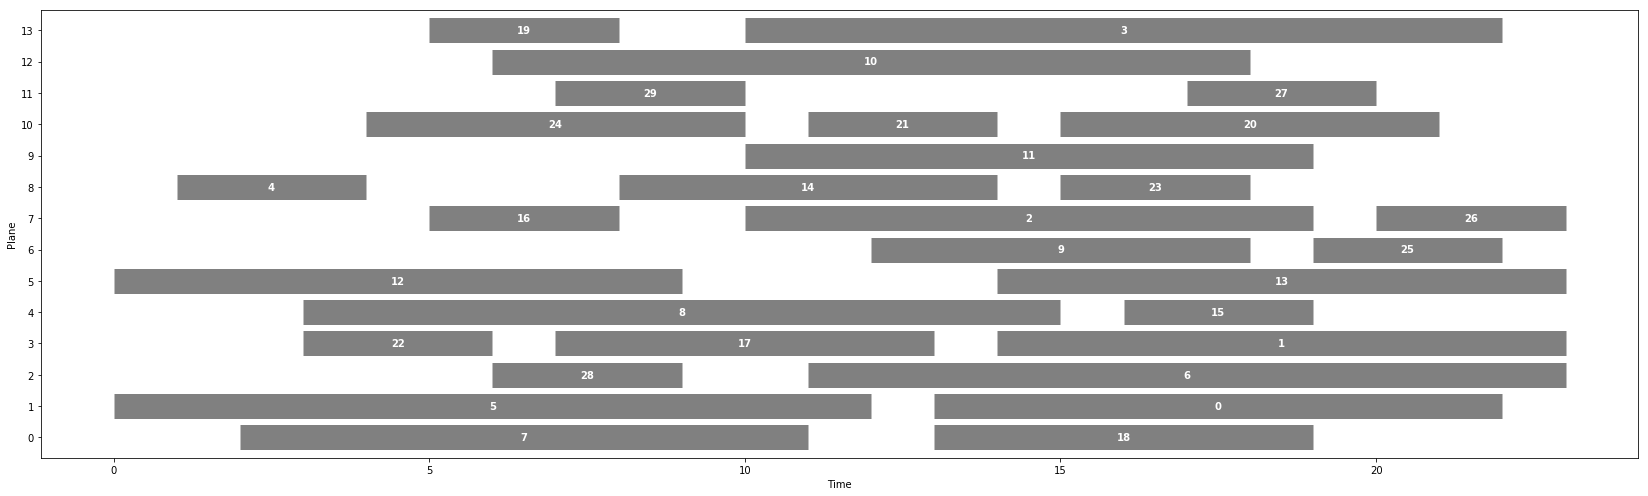

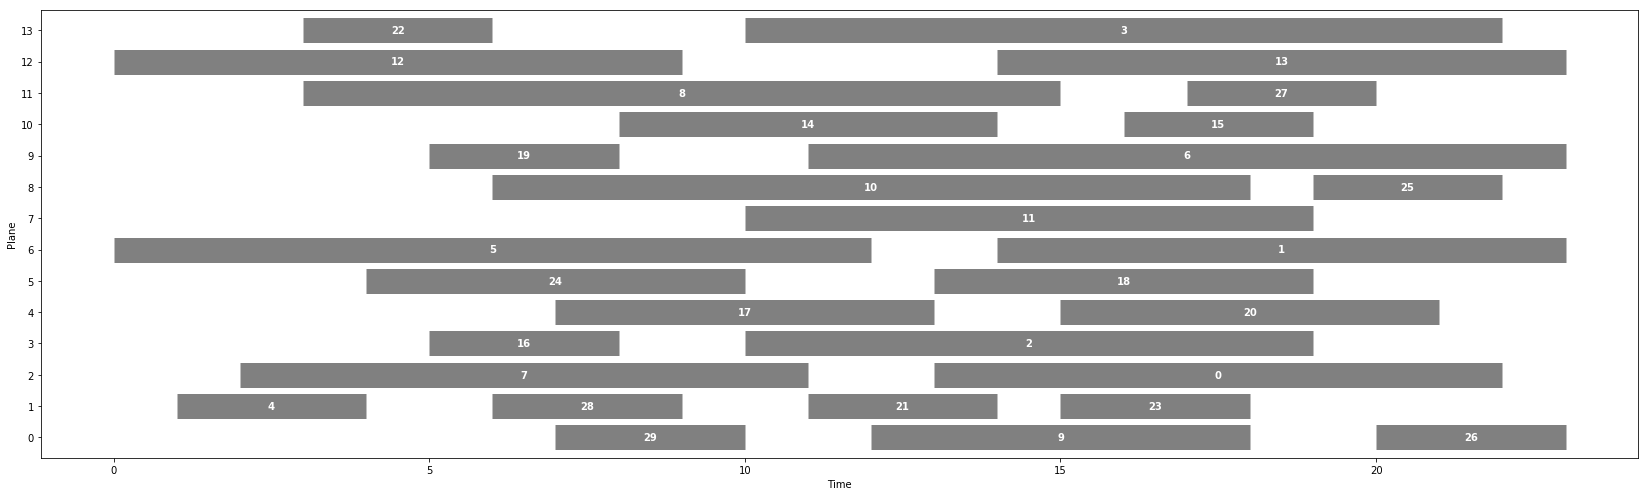

In [154]:
# create a list of pairs of potentially subsequent flights
flight_pairs = []

for flight1 in FlightData.index:
    for flight2 in FlightData.index:
        if FlightData.loc[flight1, "Arrival"] < FlightData.loc[flight2, "Departure"]:
            flight_pairs.append((flight1, flight2))

nb_flight_pairs = len(flight_pairs)

pair_riskiness = {pair: 1 if FlightData.loc[pair[0], "Arrival"] + 1 == FlightData.loc[pair[1], "Departure"] else 0
                  for pair in flight_pairs}

# create a dictionary of a pair of flights being risky or not
dummy_node_index = max(FlightData.index) + 1
start_pairs = []
end_pairs = []
for flight1 in FlightData.index:
    # dummy incoming node
    flight_pairs.append((dummy_node_index, flight1))
    start_pairs.append((dummy_node_index, flight1))
    pair_riskiness[(dummy_node_index, flight1)] = 0
    dummy_node_index += 1

    # dummy outgoing node
    flight_pairs.append((flight1, dummy_node_index))
    end_pairs.append((flight1, dummy_node_index))
    pair_riskiness[(flight1, dummy_node_index)] = 0
    dummy_node_index += 1


m = pyo.ConcreteModel("AircraftAssignment")
max_planes = FlightData.shape[0]
m.A = pyo.Set(initialize=list(range(max_planes)))
m.P = pyo.Set(initialize=pair_riskiness.keys())
m.x = pyo.Var(m.A, m.P, domain=pyo.Binary)
m.y = pyo.Var(m.A, domain=pyo.Binary)
m.c = pyo.ConstraintList()

# constraint: balance equations for all flights and planes
for aircraft in m.A:
    for flight in FlightData.index:
        m.c.add(pyo.quicksum(m.x[aircraft, pair] for pair in pair_riskiness if pair[1] == flight) == 
                pyo.quicksum(m.x[aircraft, pair] for pair in pair_riskiness if pair[0] == flight))

# each flight assigned to exactly one aircraft
for flight in FlightData.index:
    m.c.add(pyo.quicksum(m.x[aircraft, pair] for aircraft in m.A for pair in pair_riskiness if pair[1] == flight) == 1)

# each aircraft operates only one route
for aircraft in m.A:
    m.c.add(pyo.quicksum(m.x[aircraft, pair] for pair in start_pairs) <= 1)
    m.c.add(pyo.quicksum(m.x[aircraft, pair] for pair in end_pairs) <= 1)

# if aircraft serves at least one pair then it's used
for aircraft in m.A:
    for pair in pair_riskiness:
        m.c.add(m.x[aircraft, pair] <= m.y[aircraft])

# symmetry breaking constraint
for aircraft in m.A:
    if aircraft > 0:
        m.c.add(m.y[aircraft] <= m.y[aircraft - 1])

m.obj = pyo.Objective(expr = pyo.quicksum(m.y[aircraft] for aircraft in m.A), 
                      sense = pyo.minimize)

m.solver = pyo.SolverFactory("gurobi")
m.solver.solve(m)

FlightData["Aircraft"] = -1
FlightData["Aircraft"].astype('int64')

for aircraft in m.A:
    if m.y[aircraft]() > 0:
        flights = []
        for pair in flight_pairs:
            if m.x[aircraft, pair]() > 0:
                if pair[0] < N_flights:
                    flights.append(pair[0])
                if pair[1] < N_flights:
                    flights.append(pair[1])

        flights = set(flights)

        #print("Aircraft ", aircraft, " operates: ", flights)

        for flight in flights:
            FlightData.loc[flight, "Aircraft"] = aircraft

def visualize(FlightData, name):
    JOBS = sorted(list(FlightData.index))
    AIRCRAFTS = sorted(list(FlightData['Aircraft'].unique()))
    makespan = FlightData['Arrival'].max()
    nb_aircraft = FlightData["Aircraft"].max() + 1
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    #colors = mpl.cm.Dark2.colors
    #print(colors)

    fig, ax = plt.subplots(figsize = (FlightData["Arrival"].max(), nb_aircraft / 2))
    
    for flight in FlightData.index:
        xs = FlightData.loc[flight, 'Departure']
        xf = FlightData.loc[flight, 'Arrival']
        jdx = FlightData.loc[flight, "Aircraft"]
        ax.plot([xs, xf], [jdx]*2, c = 'grey', **bar_style)#c=colors[jdx], 
        ax.text((xs + xf)/2, jdx, str(flight), **text_style)
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Plane")
    ax.set_yticks(range(0, nb_aircraft))
    fig.tight_layout()
    plt.savefig(name + ".pdf")

visualize(FlightData, "Optimal schedule")

total_riskiness = sum([pair_riskiness[pair] * m.x[aircraft, pair]() for aircraft in m.A for pair in pair_riskiness])

print("Risky pairs before reoptimization: ", total_riskiness)

# Now we decide to keep the maximum number of flights at the optimal level but to minimzie their riskiness
m.c.add(pyo.quicksum(m.y[aircraft] for aircraft in m.A) <= m.obj())
m.obj = pyo.Objective(expr = pyo.quicksum(pair_riskiness[pair] * m.x[aircraft, pair]
                                          for aircraft in m.A 
                                          for pair in pair_riskiness), 
                      sense = pyo.minimize)

m.solver = pyo.SolverFactory("gurobi")
m.solver.solve(m)
print("Risky pairs after reoptimization: ", m.obj())

FlightData["Aircraft"] = -1
FlightData["Aircraft"].astype('int64')

for aircraft in m.A:
    if m.y[aircraft]() > 0:
        flights = []
        for pair in flight_pairs:
            if m.x[aircraft, pair]() > 0:
                if pair[0] < N_flights:
                    flights.append(pair[0])
                if pair[1] < N_flights:
                    flights.append(pair[1])

        flights = set(flights)

        #print("Aircraft ", aircraft, " operates: ", flights)

        for flight in flights:
            FlightData.loc[flight, "Aircraft"] = aircraft

visualize(FlightData, "Robust schedule")